Placeholder HANK code for DC housing model



In [7]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from copy import deepcopy
import importlib

# import sequence_jacobian as sj

from sequence_jacobian import grids, interpolate,simple, create_model, solved
from sequence_jacobian.blocks.stage_block import StageBlock
from sequence_jacobian.blocks.support.stages import Continuous1D, ExogenousMaker, LogitChoice

In [8]:
# key parameters 

cali = dict()

cali = {'beta': 0.96, 'Z':1.0 ,'Y':1.0, 'pi':0.00,'psi':2.0, 'sig':2.0,'mu':1.2,'pkappa':0.1,'phi': 1.5,'rhor':0.8,'epsr':0.0}


In [9]:
# steady state 

@simple
def simpleSS(beta,Y,Z,mu,phil,psi,sig):
    rstar=1/beta-1
    C=Y
    N=Y/Z
    i=rstar
    w=Z/mu
    mc=w/Z
    w_res=w-phil*(N**psi)/(C**(-sig))

    return i,C,rstar,w,N,w_res,mc


blocks_ss = [simpleSS]

nk_ss = create_model(blocks_ss, name="Simple NK SS")

unknowns_ss = {'phil': 0.8}
targets_ss = {'w_res': 0}

ss0 = nk_ss.solve_steady_state(cali, unknowns_ss, targets_ss, solver="hybr")

print(ss0['phil'])


0.8333333333333334


In [10]:
# dynamics
T=200
unknowns = ['C']
targets = ['euler_res']
exogenous = ['Z','epsr']

@simple
def Firm(C,Z,phil,psi,sig):
    Y=C
    N=Y/Z
    w=phil*(N**psi)/(C**(-sig))
    mc=w/Z
    return Y,N,w,mc

@solved(unknowns={'pi':ss0['pi']},targets=['nkpc_res'],solver='brent')
def nkpc(pi,mc,mu,beta,pkappa):
    nkpc_res=pi-beta*pi(+1)-pkappa*(mc-1/mu)
    return nkpc_res



@solved(unknowns={'i':ss0['rstar']},targets=['i_res'],solver='brent')
def Taylor(i,pi, rstar, phi,rhor,epsr):
    i_res=(1-rhor)*(rstar+phi*pi)+rhor*(i(-1))+epsr-i # Taylor Rule
    return i_res

@simple
def Euler(C,beta,sig,pi,i):
    euler_res=C**(-sig)-beta*C(+1)**(-sig)*(1+i(-1))/(1+pi)
    return euler_res

blocks=[Firm,nkpc,Taylor,Euler]
#blocks=[Firm,nkpc,Taylor2,laggedvars,Euler]
nkmodel=create_model(blocks, name="Simple NK")

G = nkmodel.solve_jacobian(ss0, unknowns, targets, exogenous, T=T)



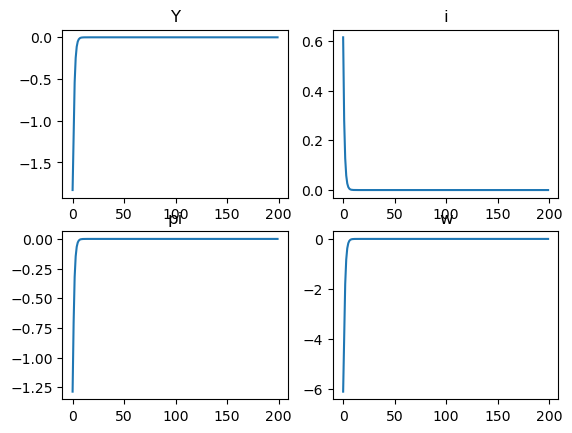

In [11]:
# Impulse responses

rshock=np.zeros([T,1])
rshock[0]=1

irflist=['Y','pi','i','w']


fgirf,ax = plt.subplots(2,2)
iter=0
for x in irflist:
    ax[np.unravel_index(iter,[2,2],order='F')].plot((G[x]['epsr']@rshock)[0:T])
    ax[np.unravel_index(iter,[2,2],order='F')].set_title(x)
    iter=iter+1



1.5